In [1]:
%matplotlib inline

import datetime as dt

import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("ticks")
from scipy.optimize import curve_fit
from scipy.optimize import minimize_scalar
import scipy.stats as stats  
import math
from pytmatrix.psd import GammaPSD

from math import gamma
# Largest Context:
#sns.set_context("talk")

#from metpy.calc import dewpoint_from_relative_humidity
#from metpy.cbook import get_test_data
#from metpy.plots import add_metpy_logo
from metpy.units import units
import xarray as xr
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import os

In [2]:
#Parsivel Data Import Cell
yyyymmdd = '20221119'

In [3]:
#Data Logger Data Import Cell
# Height of the station to calculate MSLP
hgt_example = 206.

def calc_mslp(t, p, h):
    return p * (1 - (0.0065 * h) / (t + 0.0065 * h + 273.15)) ** (-5.257)

testdata = pd.read_csv('/data/accp/a/snesbitt/scamp-2023/LoggerNet/SCAMPCR6_SCAMP_1min - Copy.dat',header=1).drop([0,1])
testdata2 = pd.read_csv('/data/accp/a/snesbitt/scamp-2023/LoggerNet/SCAMPCR6_SCAMP_1min.dat',header=1).drop([0,1])
testdata3 = pd.read_csv('/data/accp/a/snesbitt/scamp-2023/LoggerNet/SCAMPCR6_SCAMP_2022_1min.dat',header=1).drop([0,1])

data_all = pd.concat([testdata,testdata2,testdata3]).replace('NAN',np.nan)

data_all['Time_Eastern'] = pd.to_datetime(data_all['TIMESTAMP'])+pd.Timedelta(value=1, unit='hours')
# testdata_all=testdata_all.set_index('Time_Eastern')

timestamps_est = np.array(data_all.Time_Eastern, dtype=dt.datetime)
temp_times = np.zeros(len(timestamps_est),dtype=dt.datetime)
for i in range(len(timestamps_est)):
    temp_times[i] = timestamps_est[i]+pd.Timedelta(value=5, unit='hours')

data_all['UTC'] = temp_times
data_all=data_all.set_index('UTC')

data_all['Geonor_Freq'][185486] = float("nan")
data_all['Current_Depth'][185486] = float("nan")
data_all['Precip_Rate'][185487] = float("nan")

data_all['Geonor_Freq'][204447] = float("nan")
data_all['Current_Depth'][204447] = float("nan")
data_all['Precip_Rate'][204448] = float("nan")

data_all['Geonor_Freq'][223988] = float("nan")
data_all['Current_Depth'][223988] = float("nan")
data_all['Precip_Rate'][223989] = float("nan")

data_all['Geonor_Freq'][255972] = float("nan")
data_all['Current_Depth'][255972] = float("nan")
data_all['Precip_Rate'][255973] = float("nan")

data_all['Geonor_Freq'][256036] = float("nan")
data_all['Current_Depth'][256036] = float("nan")
data_all['Precip_Rate'][256037] = float("nan")

data_all['Geonor_Freq'][264175] = float("nan")
data_all['Current_Depth'][264175] = float("nan")
data_all['Precip_Rate'][264176] = float("nan")

data_all['Geonor_Freq'][268822] = float("nan")
data_all['Current_Depth'][268822] = float("nan")
data_all['Precip_Rate'][268823] = float("nan")

drop_spread = [
    0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.250,
    0.250, 0.250, 0.250, 0.250, 0.500, 0.500, 0.500, 0.500, 0.500, 1.000, 1.000,
    1.000, 1.000, 1.000, 2.000, 2.000, 2.000, 2.000, 2.000, 3.000, 3.000] #also delta

drop_diameter = [
    0.062, 0.187, 0.312, 0.437, 0.562, 0.687, 0.812, 0.937, 1.062, 1.187, 1.375, 1.625,
    1.875, 2.125, 2.375, 2.750, 3.25, 3.75, 4.25, 4.75, 5.5, 6.5, 7.5, 8.5, 9.5, 11, 
    13, 15, 17, 19, 21.5, 24.5] #diameters from the OTT Parsivel2 manual

/tmp/ipykernel_71779/174043443.py:9: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  testdata2 = pd.read_csv('/data/accp/a/snesbitt/scamp-2023/LoggerNet/SCAMPCR6_SCAMP_1min.dat',header=1).drop([0,1])
/tmp/ipykernel_71779/174043443.py:10: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  testdata3 = pd.read_csv('/data/accp/a/snesbitt/scamp-2023/LoggerNet/SCAMPCR6_SCAMP_2022_1min.dat',header=1).drop([0,1])
/tmp/ipykernel_71779/174043443.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_all['Geonor_Freq'][185486] = float("nan")
/tmp/ipykernel_71779/174043443.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [4]:
#2021-2022 dates
#dates = pd.date_range(start='2021-11-23',end='2022-03-02')
#Gauge dates
#dates = pd.date_range(start='2021-12-01',end='2022-03-02')

#2022-2023 dates
#dates = pd.date_range(start='2022-11-13',end='2023-03-04')

if yyyymmdd == '20221130':
    event_type = 'rain'
    dates = pd.date_range(start='2022-11-30',end='2022-11-30')
    xlimindexstart = dt.datetime.strptime('2022-11-30 10:00:00','%Y-%m-%d %H:%M:%S')
    xlimindexend = dt.datetime.strptime('2022-11-30 22:59:00','%Y-%m-%d %H:%M:%S')
elif yyyymmdd == '20230209':
    event_type = 'rain'
    dates = pd.date_range(start='2023-02-09',end='2023-02-09')
    xlimindexstart = dt.datetime.strptime('2023-02-09 10:00:00','%Y-%m-%d %H:%M:%S')
    xlimindexend = dt.datetime.strptime('2023-02-09 16:59:00','%Y-%m-%d %H:%M:%S') #19:07
elif yyyymmdd == '20211206':
    event_type = 'rain'
    dates = pd.date_range(start='2021-12-06',end='2021-12-06')
    xlimindexstart = dt.datetime.strptime('2021-12-06 00:00:00','%Y-%m-%d %H:%M:%S')
    xlimindexend = dt.datetime.strptime('2021-12-06 17:59:00','%Y-%m-%d %H:%M:%S')
elif yyyymmdd == '20220222':
    event_type = 'rain'
    dates = pd.date_range(start='2022-02-22',end='2022-02-22')
    xlimindexstart = dt.datetime.strptime('2022-02-22 12:00:00','%Y-%m-%d %H:%M:%S')
    xlimindexend = dt.datetime.strptime('2022-02-22 23:59:00','%Y-%m-%d %H:%M:%S')
elif yyyymmdd == '20220117':
    event_type = 'snow'
    dates = pd.date_range(start='2022-01-17',end='2022-01-17')
    xlimindexstart = dt.datetime.strptime('2022-01-17 01:00:00','%Y-%m-%d %H:%M:%S')
    xlimindexend = dt.datetime.strptime('2022-01-17 17:59:00','%Y-%m-%d %H:%M:%S')
    #xlimindexend = dt.datetime.strptime('2022-01-17 23:59:00','%Y-%m-%d %H:%M:%S')
elif yyyymmdd == '20221119':
    event_type = 'snow'
    dates = pd.date_range(start='2022-11-19',end='2022-11-19')
    #xlimindexstart = dt.datetime.strptime('2022-11-18 06:00:00','%Y-%m-%d %H:%M:%S')
    #xlimindexend = dt.datetime.strptime('2022-11-18 11:59:00','%Y-%m-%d %H:%M:%S')
    xlimindexstart = dt.datetime.strptime('2022-11-19 09:00:00','%Y-%m-%d %H:%M:%S')
    xlimindexend = dt.datetime.strptime('2022-11-19 09:59:00','%Y-%m-%d %H:%M:%S')
elif yyyymmdd == '20221224':
    event_type = 'snow'
    dates = pd.date_range(start='2022-12-24',end='2022-12-24')
    xlimindexstart = dt.datetime.strptime('2022-12-24 03:00:00','%Y-%m-%d %H:%M:%S')
    xlimindexend = dt.datetime.strptime('2022-12-24 03:59:00','%Y-%m-%d %H:%M:%S')

In [5]:
for idate in dates:

    ds = xr.open_mfdataset('/data/keeling/a/mp46/Research/Processed_Data/'+idate.strftime('%Y%m%d')+'_BUFtest.nc')

    drop_velocity = np.array(ds.velocity) 
    drop_diameter = np.array(ds.diameter)
 
    t1=idate
    #t2=idate+pd.Timedelta(1, unit='D')
    t2=idate+pd.Timedelta(hours=23,minutes=59)
    gauge_mask_for_day = (data_all.index >= t1) & (data_all.index <= t2)
    daily_gauge_data = data_all.loc[gauge_mask_for_day]
    gauge_mask_for_pd = (daily_gauge_data.index >= xlimindexstart) & (daily_gauge_data.index <= xlimindexend)

    #algorithm for data smoothing)
    if gauge_mask_for_pd.sum() > 0:

        if yyyymmdd == '20230209':
            temp_gauge_data = daily_gauge_data.loc[gauge_mask_for_pd]
            temp_parsivel_rr_data = xr.DataArray.to_series(ds.avg_rainrate)
            temp_parsivel_rr_data = np.concatenate([temp_parsivel_rr_data,np.zeros(292)],axis=0)
            temp_parsivel_rr_data = temp_parsivel_rr_data[gauge_mask_for_pd]
            temp_parsivel_ds_spectrum = np.array(ds['spectrum'])
            temp_parsivel_ds_spectrum = np.concatenate([temp_parsivel_ds_spectrum,np.zeros((292,32,32))],axis=0)
            parsivel_ds_spectrum = temp_parsivel_ds_spectrum[gauge_mask_for_pd]
            temp_parsivel_dsd = np.array(ds['dsd'])
            temp_parsivel_dsd = np.concatenate([temp_parsivel_dsd,np.zeros((292,32))],axis=0)
            parsivel_dsd = temp_parsivel_dsd[gauge_mask_for_pd]
            temp_parsivel_mass_spec = np.array(ds['raindrop_mass_spectrum_bins'])
            temp_parsivel_mass_spec = np.concatenate([temp_parsivel_mass_spec,np.zeros((292,32))],axis=0)
            parsivel_mass_spec = temp_parsivel_mass_spec[gauge_mask_for_pd]

            temp_parsivel_LWC = np.array(ds['Williams_LWC_bins'])
            temp_parsivel_LWC = np.concatenate([temp_parsivel_LWC,np.zeros((292,32))],axis=0)
            parsivel_LWC = temp_parsivel_LWC[gauge_mask_for_pd]

            #temp_psd_dbz = np.array(ds['total_dbz'])
            #temp_psd_dbz = np.concatenate([temp_psd_dbz,np.zeros((292,32))],axis=0)
            #psd_dbz = temp_psd_dbz[gauge_mask_for_pd]
        else:
            temp_gauge_data = daily_gauge_data.loc[gauge_mask_for_pd]
            temp_parsivel_rr_data = xr.DataArray.to_series(ds.avg_rainrate)
            temp_parsivel_rr_data = temp_parsivel_rr_data.loc[gauge_mask_for_pd]
            temp_parsivel_ds_spectrum = np.array(ds['spectrum'])
            parsivel_ds_spectrum = temp_parsivel_ds_spectrum[gauge_mask_for_pd]
            temp_parsivel_dsd = np.array(ds['dsd'])
            parsivel_dsd = temp_parsivel_dsd[gauge_mask_for_pd]
            temp_parsivel_IWC = np.array(ds['IWC_bins'])
            temp_parsivel_IWC = temp_parsivel_IWC[gauge_mask_for_pd]
            temp_parsivel_mass_spec = np.array(ds['raindrop_mass_spectrum_bins'])
            parsivel_mass_spec = temp_parsivel_mass_spec[gauge_mask_for_pd]
            temp_psd_dbz = np.array(ds['total_dbz'])
            psd_dbz = temp_psd_dbz[gauge_mask_for_pd]
            temp_parsivel_LWC = np.array(ds['Williams_LWC_bins'])
            parsivel_LWC = temp_parsivel_LWC[gauge_mask_for_pd]

            temp_parsivel_LWC_total = np.array(ds['Williams_LWC_total'])
            parsivel_LWC_total = temp_parsivel_LWC_total[gauge_mask_for_pd]

        thirtyminstart = xlimindexstart
        thirtyminend = thirtyminstart+pd.Timedelta(minutes=29)

        while thirtyminend <= temp_gauge_data.index[len(temp_gauge_data)-1]:

            maskminute = (temp_gauge_data.index >= thirtyminstart) & (temp_gauge_data.index <= thirtyminend)
            thirtymindata = temp_gauge_data.loc[maskminute] 
            # here, current depth is in mm
            P = np.diff(pd.to_numeric(thirtymindata['Current_Depth'],errors='coerce')) #P is in mm/min
            P = np.concatenate([[0],P],axis=0)
            #P = sorted(P)
            flaggedvalues = (pd.to_numeric(P) <= 0.05)
            for i in range(len(P)):
                #if P[i] < 0: #if P value is negative
                 #   P[i] = 0 #make it equal to 0
                if flaggedvalues[i] == True: #if the value is less than 0.1
                    if i == 29: #check to see if it's the last value in the 30 mins
                        if P[i] < 0.05: #if so, check to see if it's less than 0.05
                            P[i] = P[i-1] + P[i]
                            #P[i] = 0 #if so, make it O because it means it's still below the minimum threshold
                    else: #if it's not the last value
                        P[i+1] = P[i+1] + P[i] #take the P value and add it to the subsequent value
                        P[i] = 0 #then make current value equal to 0
            if thirtyminstart == xlimindexstart:
                proc_precip_rate = P #in mm/min
            else:
                proc_precip_rate = np.concatenate((proc_precip_rate,P))
            thirtyminstart = thirtyminend +pd.Timedelta(minutes=1)
            thirtyminend = thirtyminstart+pd.Timedelta(minutes=29)

        precip_temp = pd.to_numeric(temp_gauge_data['Current_Depth'],errors='coerce')
        parsivel_daily_temp = np.nancumsum(temp_parsivel_rr_data/60)
        proc_daily_temp = np.nancumsum(proc_precip_rate)
        freq_temp = pd.to_numeric(temp_gauge_data['Geonor_Freq'],errors='coerce')
        date_temp = pd.to_datetime(temp_gauge_data.index) #+ dt.timedelta(hours=1)

        if idate == dates[0]:
            proc_daily = proc_daily_temp
            parsivel_daily = parsivel_daily_temp
            precip = precip_temp
            freq = freq_temp
            date = date_temp
            parsivelrr = temp_parsivel_rr_data
        else:
            proc_daily = np.concatenate((proc_daily,proc_daily_temp))
            parsivel_daily = np.concatenate((parsivel_daily,parsivel_daily_temp))
            precip = np.concatenate((precip,precip_temp))
            freq = np.concatenate((freq,freq_temp))
            proc_precip_rate = proc_precip_rate
            date = np.concatenate((date,date_temp))
            parsivelrr = np.concatenate((parsivelrr,temp_parsivel_rr_data))

#################################################################################################################################################################        
        
        def power_law(x, a, b):
            return a*np.power(x, b)

        summed_spectrum = parsivel_ds_spectrum.sum(axis=0)
        separate_diameters = []
        separate_velocities = []

        time_labels = np.array(date)

        snow_upper_limit = 0.8*np.power(drop_diameter, 0.16) + 1
        snow_lower_limit = 0.8*np.power(drop_diameter, 0.16) - 1
        rain_upper_limit = 17.67*np.power(drop_diameter/10, 0.67) + 1 
        rain_lower_limit = 17.67*np.power(drop_diameter/10, 0.67) - 1

        if event_type == 'snow':
            rain_dict_temp = {}

            for d,u,l in zip(range(len(drop_diameter)), rain_upper_limit, rain_lower_limit):
                rain_indis = np.where( (drop_velocity>l))
                rain_dict_temp[d] = rain_indis

            rain_indi_pairs_2D = []
            for rain_diam, rain_indis in rain_dict_temp.items():
                for i in rain_indis[0]:
                    if summed_spectrum[i, rain_diam] > 0:
                        rain_indi_pairs_2D.append((rain_diam,i))

            rain_triple_time_dia_vel = []

            for i, j in rain_indi_pairs_2D:
                local_dia = drop_diameter[i]
                local_veloc = drop_velocity[j]
                times = parsivel_ds_spectrum[:,j,i]
                time_indis = np.where(times>0)
                for t in time_indis[0]:
                    rain_triple_time_dia_vel.append((local_dia,local_veloc,time_labels[t]))

            rain_triple_time_dia_vel = np.array(rain_triple_time_dia_vel)

            ####################################################################

            snow_dict_temp = {}

            for d,u,l in zip(range(len(drop_diameter)), snow_upper_limit, snow_lower_limit):
                snow_indis = np.where((drop_velocity<u) & (drop_velocity>l))
                snow_dict_temp[d] = snow_indis

            snow_indi_pairs_2D = []
            for snow_diam, snow_indis in snow_dict_temp.items():
                for i in snow_indis[0]:
                    if summed_spectrum[i, snow_diam] > 0:
                        snow_indi_pairs_2D.append((snow_diam,i))

            snow_triple_time_dia_vel = []

            for i, j in snow_indi_pairs_2D:
                local_dia = drop_diameter[i]
                local_veloc = drop_velocity[j]
                times = parsivel_ds_spectrum[:,j,i]
                time_indis = np.where(times>0)
                for t in time_indis[0]:
                    snow_triple_time_dia_vel.append((local_dia,local_veloc,time_labels[t]))

            snow_triple_time_dia_vel = np.array(snow_triple_time_dia_vel)

            ########################################################################################

            mixed_dict_temp = {}

            for d,u,l in zip(range(len(drop_diameter)), snow_upper_limit, rain_lower_limit):
                mixed_indis = np.where((drop_velocity>u) & (drop_velocity<l))
                mixed_dict_temp[d] = mixed_indis

            mixed_indi_pairs_2D = []
            for mixed_diam, mixed_indis in mixed_dict_temp.items():
                for i in mixed_indis[0]:
                    if summed_spectrum[i, mixed_diam] > 0:
                        mixed_indi_pairs_2D.append((mixed_diam,i))

            mixed_triple_time_dia_vel = []

            for i, j in mixed_indi_pairs_2D:
                local_dia = drop_diameter[i]
                local_veloc = drop_velocity[j]
                times = parsivel_ds_spectrum[:,j,i]
                time_indis = np.where(times>0)
                for t in time_indis[0]:
                    mixed_triple_time_dia_vel.append((local_dia,local_veloc,time_labels[t]))

            mixed_triple_time_dia_vel = np.array(mixed_triple_time_dia_vel)

            ########################################################################################

            unknown_dict_temp = {}

            for d,u,l,rl in zip(range(len(drop_diameter)), snow_upper_limit, snow_lower_limit, rain_lower_limit):
                unknown_indis = np.where((drop_velocity>rl) & (l<drop_velocity) & (drop_velocity<u))
                unknown_dict_temp[d] = unknown_indis

            unknown_indi_pairs_2D = []
            for unknown_diam, unknown_indis in unknown_dict_temp.items():
                for i in unknown_indis[0]:
                    if summed_spectrum[i, unknown_diam] > 0:
                        unknown_indi_pairs_2D.append((unknown_diam,i))

            unknown_triple_time_dia_vel = []

            for i, j in unknown_indi_pairs_2D:
                local_dia = drop_diameter[i]
                local_veloc = drop_velocity[j]
                times = parsivel_ds_spectrum[:,j,i]
                time_indis = np.where(times>0)
                for t in time_indis[0]:
                    unknown_triple_time_dia_vel.append((local_dia,local_veloc,time_labels[t]))

            unknown_triple_time_dia_vel = np.array(unknown_triple_time_dia_vel)

            ################################################################################################################################################################################
            
            # Fit the power-law data
            snow_pars, snow_cov = curve_fit(f=power_law, xdata=snow_triple_time_dia_vel[:,0]/1000, ydata=snow_triple_time_dia_vel[:,1], p0=[0.006, 0.05], bounds=(0, [np.inf, 1]), check_finite=False)
            # Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
            snow_stdevs = np.sqrt(np.diag(snow_cov))
            # Calculate the residuals
            snow_res = ds.velocity - power_law(ds.diameter, *snow_pars)

            rain_pars, rain_cov = curve_fit(f=power_law, xdata=rain_triple_time_dia_vel[:,0]/1000, ydata=rain_triple_time_dia_vel[:,1], p0=[0.006, 0.05], bounds=(0, [np.inf, 1]), check_finite=False)
            # Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
            rain_stdevs = np.sqrt(np.diag(rain_cov))
            # Calculate the residuals
            rain_res = ds.velocity - power_law(ds.diameter, *rain_pars)

            snow_power_law_vt = snow_pars[0]*np.power(ds.diameter/1000, snow_pars[1])
            snow_power_law_vt = np.array(snow_power_law_vt)
            snow_power_law_vt = np.reshape(np.array(snow_power_law_vt),(1,-1))

            rain_power_law_vt = rain_pars[0]*np.power(ds.diameter/1000, rain_pars[1])
            rain_power_law_vt = np.array(rain_power_law_vt)
            rain_power_law_vt = np.reshape(np.array(rain_power_law_vt),(1,-1))

            ###############################################################################

        else:
            rain_dict_temp = {}

            for d,u,l in zip(range(len(drop_diameter)), rain_upper_limit, rain_lower_limit):
                rain_indis = np.where( (drop_velocity>0))
                rain_dict_temp[d] = rain_indis

            rain_indi_pairs_2D = []
            for rain_diam, rain_indis in rain_dict_temp.items():
                for i in rain_indis[0]:
                    if summed_spectrum[i, rain_diam] > 0:
                        rain_indi_pairs_2D.append((rain_diam,i))

            rain_triple_time_dia_vel = []

            for i, j in rain_indi_pairs_2D:
                local_dia = drop_diameter[i]
                local_veloc = drop_velocity[j]
                times = parsivel_ds_spectrum[:,j,i]
                time_indis = np.where(times>0)
                for t in time_indis[0]:
                    rain_triple_time_dia_vel.append((local_dia,local_veloc,time_labels[t]))

            rain_triple_time_dia_vel = np.array(rain_triple_time_dia_vel)

            rain_pars, rain_cov = curve_fit(f=power_law, xdata=rain_triple_time_dia_vel[:,0]/1000, ydata=rain_triple_time_dia_vel[:,1], p0=[0.006, 0.05], bounds=(0, [np.inf, 1]), check_finite=False)
            # Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
            rain_stdevs = np.sqrt(np.diag(rain_cov))
            # Calculate the residuals
            rain_res = ds.velocity - power_law(ds.diameter, *rain_pars)

            rain_power_law_vt = rain_pars[0]*np.power(ds.diameter/1000, rain_pars[1])
            rain_power_law_vt = np.array(rain_power_law_vt)
            rain_power_law_vt = np.reshape(np.array(rain_power_law_vt),(1,-1))

        # Locatelli and Hobbs 1974, snow
        LH_unrimed_aggs_vt = 0.8*np.power(ds.diameter, 0.16)
        LH_rimed_aggs_vt = 0.79*np.power(ds.diameter, 0.27)

        # Rosenow et al 2014, snow

        # Beard 1976, rain
        # v = dynamic viscosity*Reynolds number/fluid density*equivalent spherical diameter
        # Gunn and Kinzer, 1949

        # Atlas and Ulbrich, 1977, rain
        Atlas_and_Ulbrich_rain = 17.67*np.power(ds.diameter/10, 0.67)

        # Uplinger 1981, as described in Serio et al, 2019
        Uplinger_rain = 48.74*ds.diameter/10*np.exp(-1.95*(ds.diameter/10))

        # Leone and Pica 1993 using vt measurements from Beard 1976 and Gunnn and Kinzer 1949, as described in Serio et al, 2019
        Leone_and_Pica_rain = 49*ds.diameter/10*np.exp(-2*(ds.diameter/10))

#################################################################################################################################################################
        
        if event_type == 'snow':
            if yyyymmdd == '20220117':
                #rainrate_total = np.zeros((len(temp_parsivel_IWC),))
                rainrate_bins = np.multiply(np.array(rain_power_law_vt[0,0:16]),parsivel_LWC[:,0:16]) #where LWC is in g/m^3 and velocity is in m/s
                #preciprate_bins = np.array(lwc_and_vt)
                #preciprate_bins = np.multiply(preciprate_bins,3.6) # divide by 1000 to get g into kg, multiply by 3600 to get s into hr

                snowrate_bins = np.multiply(temp_parsivel_IWC[:,16:32], np.array(snow_power_law_vt[0,16:32]))
                preciprate_bins = np.hstack((rainrate_bins,snowrate_bins))
                
                preciprate_bins = np.multiply(preciprate_bins,3.6)
                preciprate_total = preciprate_bins.sum(axis=1)
                preciprate_accumulation = np.nancumsum(preciprate_total/60)

                #preciprate_bins = np.zeros((len(temp_parsivel_IWC),32))
                #IWC_conditions = temp_parsivel_IWC.sum(axis=1)
                #for i in range(len(temp_parsivel_IWC)):
                    #if IWC_conditions[i] < 0.1:
                        #preciprate_bins[i] = np.multiply(np.array(rain_power_law_vt),parsivel_LWC[i,:]) #where LWC is in g/m^3 and velocity is in m/s
                        #preciprate_bins[i] = np.array(lwc_and_vt)
                        #preciprate_bins[i] = np.multiply(preciprate_bins,3.6) # divide by 1000 to get g into kg, multiply by 3600 to get s into hr
                    #else:
                        #preciprate_bins[i] = np.multiply(temp_parsivel_IWC[i,:], np.array(snow_power_law_vt))
                #preciprate_bins = np.multiply(preciprate_bins,3.6)
                #preciprate_total = preciprate_bins.sum(axis=1)
                #preciprate_accumulation = np.nancumsum(preciprate_total/60)
            else:
                snowrate_bins = np.multiply(temp_parsivel_IWC, np.array(snow_power_law_vt))
                snowrate_bins = np.multiply(snowrate_bins,3600/1000)
                preciprate_total = snowrate_bins.sum(axis=1)
                preciprate_accumulation = np.nancumsum(preciprate_total/60)

            #Matrosov
            Matrosov_reflectivity = np.multiply(56,np.power(preciprate_total,1.2))
            Matrosov_reflectivity_factor = np.multiply(10,np.log10(Matrosov_reflectivity))

            #MRMS
            MRMS_reflectivity = np.multiply(75,np.power(preciprate_total,2))
            MRMS_reflectivity_factor = np.multiply(10,np.log10(MRMS_reflectivity))

            #Holroyd 1999
            Holroyd_reflectivity = np.multiply(150,np.power(preciprate_total,2))
            Holroyd_reflectivity_factor = np.multiply(10,np.log10(Holroyd_reflectivity))

            WS_Cleveland_reflectivity =  np.multiply(304,np.power(preciprate_total,2))
            WS_Cleveland_reflectivity_factor = np.multiply(10,np.log10(WS_Cleveland_reflectivity))

            WS_Albany_reflectivity =  np.multiply(304,np.power(preciprate_total,2))
            WS_Albany_reflectivity_factor = np.multiply(10,np.log10(WS_Albany_reflectivity))
            
        else:
            lwc_and_vt = np.multiply(np.array(rain_power_law_vt),parsivel_LWC) #where LWC is in g/m^3 and velocity is in m/s
            preciprate_bins = np.array(lwc_and_vt)
            preciprate_bins = np.multiply(preciprate_bins,3.6) # divide by 1000 to get g into kg, multiply by 3600 to get s into hr
            preciprate_total = preciprate_bins.sum(axis=1)
            preciprate_accumulation = np.nancumsum(preciprate_total/60)

            rainrate_trial = (0.6 * np.pi * 1e-03 * rain_power_law_vt * parsivel_dsd * drop_spread * np.array(drop_diameter) ** 3)
            rainrate_trial_total = rainrate_trial.sum(axis=1)
            rainrate_total_daily_accum = np.nancumsum(rainrate_trial_total/60)

            # Marshall and Palmer
            Reinhart_reflectivity = np.multiply(200,np.power(preciprate_total,1.6))
            Reinhart_reflectivity_factor = np.multiply(10,np.log10(Reinhart_reflectivity))

            # Default WSR-88D, Rauber and Nesbitt textbook
            Default_reflectivity = np.multiply(300,np.power(preciprate_total,1.4))
            Default_reflectivity_factor = np.multiply(10,np.log10(Default_reflectivity))

            # East Cool Season WSR-88D,Rauber and Nesbitt textbook
            EastCool_reflectivity = np.multiply(130,np.power(preciprate_total,2))
            EastCool_reflectivity_factor = np.multiply(10,np.log10(EastCool_reflectivity))

#################################################################################################################################################################   

data = pd.DataFrame({'Current Depth': np.array(precip),
        'Processed Gauge Precip Rate': np.array(proc_precip_rate*60)* units('mm/hr'),
        'Processed Gauge Precip Accumulation': np.array(proc_daily)* units('mm'),
        'Parsivel Rainrate': np.array(parsivelrr/6)* units('mm/hr'),
        'Parsivel Precip Accumulation': np.array(parsivel_daily/6),
        'Calculated Parsivel Rainrate': np.array(preciprate_total)* units('mm/hr'),
        'Calculated Parsivel Accumulation': np.array(preciprate_accumulation),
        'times': np.array(date),
        'Frequency': np.array(freq)})
data.index=date

#################################################################################################################################################################   

if dates[0] < dt.date(2023,3,2):
    interval = dt.timedelta(minutes=29)
    period_start = xlimindexstart
    #avg_gauge_adjustment_needed_perpd_accum = []

    while period_start < xlimindexend:

        period_end = min(period_start + interval, xlimindexend)

        maskminute = (data.index >= period_start) & (data.index <= period_end)
        thirtymindata = data.loc[maskminute] 

        parstogauge_difference_accum = np.divide(thirtymindata['Processed Gauge Precip Accumulation'],thirtymindata['Parsivel Precip Accumulation'])
        gaugetopars_difference_accum = np.divide(thirtymindata['Parsivel Precip Accumulation'],thirtymindata['Processed Gauge Precip Accumulation'])
        avgparsval_accum = np.sum(thirtymindata['Parsivel Precip Accumulation'])/len(thirtymindata)
        avggaugeval_accum = np.sum(thirtymindata['Processed Gauge Precip Accumulation'])/len(thirtymindata)

        parstogauge_difference_rr = np.divide(thirtymindata['Processed Gauge Precip Rate'],thirtymindata['Parsivel Rainrate'])
        gaugetopars_difference_rr = np.divide(thirtymindata['Parsivel Rainrate'],thirtymindata['Processed Gauge Precip Rate'])
        avgparsval_rr = np.sum(thirtymindata['Parsivel Rainrate'])/len(thirtymindata)
        avggaugeval_rr = np.sum(thirtymindata['Processed Gauge Precip Rate'])/len(thirtymindata)

        avgpercentdiff_accum = np.divide(avgparsval_accum,avggaugeval_accum)
        avgpercentdiff_rr = np.divide(avgparsval_rr,avggaugeval_rr)
    
        if period_start == xlimindexstart:
            parstogauge_adjustment_needed_accum = parstogauge_difference_accum
            gaugetopars_adjustment_needed_accum = gaugetopars_difference_accum
            parstogauge_adjustment_needed_rr = parstogauge_difference_rr
            gaugetopars_adjustment_needed_rr = gaugetopars_difference_rr
        else:
            parstogauge_adjustment_needed_accum = np.concatenate((parstogauge_adjustment_needed_accum,parstogauge_difference_accum))
            gaugetopars_adjustment_needed_accum = np.concatenate((gaugetopars_adjustment_needed_accum,gaugetopars_difference_accum))
            parstogauge_adjustment_needed_rr = np.concatenate((parstogauge_adjustment_needed_rr,parstogauge_difference_rr))
            gaugetopars_adjustment_needed_rr = np.concatenate((gaugetopars_adjustment_needed_rr,gaugetopars_difference_rr))
    
        #avg_gauge_adjustment_needed_perpd_accum.append((period_start, period_end, avgpercentdiff_accum))

        period_start = period_end + dt.timedelta(minutes=1)

    avg_adjustment_value_accum = np.divide(np.nansum(gaugetopars_adjustment_needed_accum),len(gaugetopars_adjustment_needed_accum))
    avg_adjustment_value_rr = np.divide(np.nansum(gaugetopars_adjustment_needed_rr),len(gaugetopars_adjustment_needed_rr))
    #data['Processed Gauge Precip Accumulation'] = list(data['Processed Gauge Precip Accumulation'])*gaugetopars_adjustment_needed_accum
    #data['Processed Gauge Precip Rate'] = list(data['Processed Gauge Precip Rate'])*gaugetopars_adjustment_needed_rr

/tmp/ipykernel_71779/1736996685.py:400: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if dates[0] < dt.date(2023,3,2):


In [6]:
# Gauge Adjustment Algorithm
'''
if dates[0] < dt.date(2023,3,2):
    interval = dt.timedelta(minutes=29)
    period_start = xlimindexstart
    avg_gauge_adjustment_needed_perpd = []

    while period_start < xlimindexend:

        period_end = min(period_start + interval, xlimindexend)

        maskminute = (usefuldata.index >= period_start) & (usefuldata.index <= period_end)
        thirtymindata = usefuldata.loc[maskminute] 

        parstogauge_difference = np.divide(thirtymindata['Processed Precip Accumulation'],thirtymindata['Parsivel Daily Precip'])
        gaugetopars_difference = np.divide(thirtymindata['Parsivel Daily Precip'],thirtymindata['Processed Precip Accumulation'])
        avgparsval = np.sum(thirtymindata['Parsivel Daily Precip'])/len(thirtymindata)
        avggaugeval = np.sum(thirtymindata['Processed Precip Accumulation'])/len(thirtymindata)

        avgpercentdiff = np.divide(avgparsval,avggaugeval)
    
        if period_start == xlimindexstart:
            parstogauge_adjustment_needed = parstogauge_difference
            gaugetopars_adjustment_needed = gaugetopars_difference
        else:
            parstogauge_adjustment_needed = np.concatenate((parstogauge_adjustment_needed,parstogauge_difference))
            gaugetopars_adjustment_needed = np.concatenate((gaugetopars_adjustment_needed,gaugetopars_difference))
    
        avg_gauge_adjustment_needed_perpd.append((period_start, period_end, avgpercentdiff))
        period_start = period_end + dt.timedelta(minutes=1)

    usefuldata['Processed Precip Accumulation'] = list(usefuldata['Processed Precip Accumulation'])*gaugetopars_adjustment_needed
    '''

"\nif dates[0] < dt.date(2023,3,2):\n    interval = dt.timedelta(minutes=29)\n    period_start = xlimindexstart\n    avg_gauge_adjustment_needed_perpd = []\n\n    while period_start < xlimindexend:\n\n        period_end = min(period_start + interval, xlimindexend)\n\n        maskminute = (usefuldata.index >= period_start) & (usefuldata.index <= period_end)\n        thirtymindata = usefuldata.loc[maskminute] \n\n        parstogauge_difference = np.divide(thirtymindata['Processed Precip Accumulation'],thirtymindata['Parsivel Daily Precip'])\n        gaugetopars_difference = np.divide(thirtymindata['Parsivel Daily Precip'],thirtymindata['Processed Precip Accumulation'])\n        avgparsval = np.sum(thirtymindata['Parsivel Daily Precip'])/len(thirtymindata)\n        avggaugeval = np.sum(thirtymindata['Processed Precip Accumulation'])/len(thirtymindata)\n\n        avgpercentdiff = np.divide(avgparsval,avggaugeval)\n    \n        if period_start == xlimindexstart:\n            parstogauge_ad

In [7]:
'''
# Power Law to Find Vt as a Function of D (cm) / Rainrate Calculation
# Function to calculate the power-law with constants a and b
        def power_law(x, a, b):
            return a*np.power(x, b)
        
        summed_spectrum = parsivel_ds_spectrum.sum(axis=0)
        separate_diameters = []
        separate_velocities = []
        terminal_velocities = []

        for i in range(len(summed_spectrum)):
            for j in range(len(summed_spectrum)):
                niftycount = math.floor(summed_spectrum[j,i])
                if niftycount > 0:
                    separate_diameters.extend([float(ds.diameter[i])]*niftycount)
                    separate_velocities.extend([float(ds.velocity[j])]*niftycount)

        if event_type == 'snow':
            separate_diameters = np.array(separate_diameters)
            separate_velocities = np.array(separate_velocities)

            particlemask = (np.array(separate_diameters) >= .043) 
            filtered_diameters = separate_diameters[particlemask]
            filtered_velocities = separate_velocities[particlemask]
        else:
            filtered_diameters = separate_diameters
            filtered_velocities = separate_velocities

        filtered_diameters = np.array(filtered_diameters)/10
        separate_diameters = np.array(separate_diameters)/10
        # Fit the dummy power-law data
        pars, cov = curve_fit(f=power_law, xdata=filtered_diameters, ydata=filtered_velocities, p0=[0.006, 0.05], bounds=(0, [np.inf, 1]))
        # Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
        stdevs = np.sqrt(np.diag(cov))
        # Calculate the residuals
        res = ds.velocity - power_law(ds.diameter, *pars)

        power_law_vt = pars[0]*np.power(ds.diameter/10, pars[1])

        # Locatelli and Hobbs 1974, snow
        LH_unrimed_aggs_vt = 0.8*np.power(ds.diameter, 0.16)
        LH_rimed_aggs_vt = 0.79*np.power(ds.diameter, 0.27)

        # Rosenow et al 2014, snow
        

        # Beard 1976, rain
        # v = dynamic viscosit*Reynolds number/fluid density*equivalent spherical diameter

        # Gunn and Kinzer, 1949

        # Atlas and Ulbrich, 1977, rain
        Atlas_and_Ulbrich_rain = 17.67*np.power(ds.diameter/10, 0.187)

        # Uplinger 1981, as described in Serio et al, 2019
        Uplinger_rain = 48.74*np.power(ds.diameter/10, -1.95*(ds.diameter/10))

        # Leone and Pica 1993 using vt measurements from Beard 1976 and Gunnn and Kinzer 1949, as described in Serio et al, 2019
        Leone_and_Pica_rain = 49*np.power(ds.diameter/10, -2*(ds.diameter/10))

###########################################################################################################
        #dmaxs = np.array([0.1245, 0.2495, 0.3745, 0.4995, 0.6245, 0.7495, 0.8745, 0.9995, 1.1245, 1.2495,
                 #1.5, 1.75, 2, 2.25, 2.5, 3, 3.5, 3.97, 4.5, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 23, 26])

        #dmins = np.array([0, 0.1245, 0.2495, 0.3745, 0.4995, 0.6245, 0.7495, 0.8745, 0.9995, 1.1245, 1.25,
                 #1.5, 1.75, 2, 2.25, 2.5, 3, 3.47, 4, 4.5, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 23])

        #drop_spread = np.array([
            #0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.250,
            #0.250, 0.250, 0.250, 0.250, 0.500, 0.500, 0.500, 0.500, 0.500, 1.000, 1.000,
            #1.000, 1.000, 1.000, 2.000, 2.000, 2.000, 2.000, 2.000, 3.000, 3.000]) #also delta

        #rainrate_wo_dsd = []
        #rainrate_bins = np.zeros((len(parsivel_dsd),32))
        #rainrate_total = np.zeros((len(parsivel_dsd),1))

        #drop_spread = drop_spread/10
        #dmaxs = dmaxs/10
        #dmins = dmins/10
        #num = 0.00359*pars[0]
        #denom_and_exp = 2.1 + pars[1] + 1
        #coeff_frac = num/denom_and_exp

        #for i in range(len(dmaxs)):
            #dmax_calc = coeff_frac*np.power(dmaxs[i],denom_and_exp)
            #dmin_calc = coeff_frac*np.power(dmins[i],denom_and_exp)
            #rainrate = dmax_calc - dmin_calc
            #rainrate_wo_dsd.append(rainrate)

        #for i in range(len(parsivel_dsd)):
            #rainrate_bins[i,:] = np.multiply(parsivel_dsd[i],1000)*rainrate_wo_dsd
            #rainrate_total[i] = np.sum(rainrate_bins[i,:]*3600)
'''

"\n# Power Law to Find Vt as a Function of D (cm) / Rainrate Calculation\n# Function to calculate the power-law with constants a and b\n        def power_law(x, a, b):\n            return a*np.power(x, b)\n        \n        summed_spectrum = parsivel_ds_spectrum.sum(axis=0)\n        separate_diameters = []\n        separate_velocities = []\n        terminal_velocities = []\n\n        for i in range(len(summed_spectrum)):\n            for j in range(len(summed_spectrum)):\n                niftycount = math.floor(summed_spectrum[j,i])\n                if niftycount > 0:\n                    separate_diameters.extend([float(ds.diameter[i])]*niftycount)\n                    separate_velocities.extend([float(ds.velocity[j])]*niftycount)\n\n        if event_type == 'snow':\n            separate_diameters = np.array(separate_diameters)\n            separate_velocities = np.array(separate_velocities)\n\n            particlemask = (np.array(separate_diameters) >= .043) \n            filtered_di

In [8]:
'''
for idate in dates:

    ds = xr.open_mfdataset('/data/keeling/a/mp46/Research/Processed_Data/'+idate.strftime('%Y%m%d')+'_BUFtest.nc')
    parsivelrr = ds.avg_rainrate
  
    t1=idate
    t2=idate+pd.Timedelta(1, unit='D')
    mask = (data_all.index >= t1) & (data_all.index <= t2)

    #algorithm for data smoothing)
    if mask.sum() > 0:

        tempdata = data_all.loc[mask]
        
        thirtyminstart = idate
        thirtyminend = thirtyminstart+pd.Timedelta(minutes=29)

        parsivelavgrrseries = xr.DataArray.to_series(ds.avg_rainrate)
        parsivelrr_temp = np.concatenate([parsivelavgrrseries,[0]],axis=0)

        while thirtyminend < tempdata.index[len(tempdata)-1]:

            maskminute = (tempdata.index >= thirtyminstart) & (tempdata.index <= thirtyminend)
            thirtymindata = tempdata.loc[maskminute] 

            P = np.diff(pd.to_numeric(thirtymindata['Current_Depth'],errors='coerce'))
            P = np.concatenate([[0],P],axis=0)
            #P = sorted(P)
            flaggedvalues = (pd.to_numeric(P) <= 0.05)
            for i in range(len(P)):
                #if P[i] < 0: #if P value is negative
                 #   P[i] = 0 #make it equal to 0
                if flaggedvalues[i] == True: #if the value is less than 0.1
                    if i == 29: #check to see if it's the last value in the 30 mins
                        if P[i] < 0.05: #if so, check to see if it's less than 0.05
                            P[i] = P[i-1] + P[i]
                            #P[i] = 0 #if so, make it O because it means it's still below the minimum threshold
                    else: #if it's not the last value
                        P[i+1] = P[i+1] + P[i] #take the P value and add it to the subsequent value
                        P[i] = 0 #then make current value equal to 0
            if thirtyminstart == dates[0]:
                proc_precip_rate = P
            else:
                proc_precip_rate = np.concatenate((proc_precip_rate,P))
            thirtyminstart = thirtyminend +pd.Timedelta(minutes=1)
            thirtyminend = thirtyminstart+pd.Timedelta(minutes=29)

        proc_precip_rate = np.append(proc_precip_rate,float("nan"))

        precip_temp = pd.to_numeric(tempdata['Current_Depth'],errors='coerce')
        precip_rate_temp = np.diff(pd.to_numeric(tempdata['Current_Depth'],errors='coerce'))
        precip_rate_temp[precip_rate_temp < 0.05] = 0.
        precip_rate_temp = np.concatenate([[0],precip_rate_temp],axis=0)
        precip_daily_temp = np.nancumsum(precip_rate_temp)
        parsivel_daily_temp = np.nancumsum(parsivelrr_temp/60)
        proc_daily_temp = np.nancumsum(proc_precip_rate)
        freq_temp = pd.to_numeric(tempdata['Geonor_Freq'],errors='coerce')
        date_temp = pd.to_datetime(tempdata.index) #+ dt.timedelta(hours=1)

        if idate == dates[0]:
            precip_daily = precip_daily_temp
            proc_daily = proc_daily_temp
            parsivel_daily = parsivel_daily_temp
            precip = precip_temp
            freq = freq_temp
            date = date_temp
            precip_rate = precip_rate_temp
            parsivelrr = parsivelrr_temp
        else:
            precip_daily = np.concatenate((precip_daily,precip_daily_temp))
            proc_daily = np.concatenate((proc_daily,proc_daily_temp))
            parsivel_daily = np.concatenate((parsivel_daily,parsivel_daily_temp))
            precip = np.concatenate((precip,precip_temp))
            precip_rate = np.concatenate((precip_rate,precip_rate_temp))
            freq = np.concatenate((freq,freq_temp))
            proc_precip_rate = proc_precip_rate
            date = np.concatenate((date,date_temp))
            parsivelrr = np.concatenate((parsivelrr,parsivelrr_temp))

        if yyyymmdd == '20230209':
            parsivelrr = np.concatenate([parsivelrr,np.zeros(292)],axis=0)
            parsivel_daily = np.concatenate([parsivel_daily,np.zeros(292)],axis=0)

        parsivel_daily = np.divide(parsivel_daily,86400)
        proc_daily = np.divide(proc_daily,86400)

        #GeonorP = np.multiply(0.0165554,freq - 1054.6) + np.multiply(0.00000917994,np.square(freq - 1054.6))
    
data = pd.DataFrame({'Precipitation rate (mm/hr)': np.array(precip_rate*60)* units('mm'),
        #'Geonor Equation Accum (cm)': np.array(GeonorP - GeonorP[1])* units('cm'),
        'Current Depth': np.array(precip),
        'Precip accumulation (mm)': np.array(precip_daily)* units('mm'), 
        'Processed Precip Rate': np.array(proc_precip_rate*60)* units('mm'),
        'Processed Precip Accumulation': np.array(proc_daily)* units('mm'),
        'Parsivel Rainrate (mm/hr)': np.array(parsivelrr),
        'Parsivel Daily Precip': np.array(parsivel_daily),
        'times': np.array(date),
        'Frequency': np.array(freq)})
data.index=date

mask = (data.index >= xlimindexstart) & (data.index <= xlimindexend)
usefuldata = data.loc[mask]

if dates[0] < dt.date(2023,3,2):
    interval = dt.timedelta(minutes=29)
    period_start = xlimindexstart
    avg_gauge_adjustment_needed_perpd = []

    while period_start < xlimindexend:

        period_end = min(period_start + interval, xlimindexend)

        maskminute = (usefuldata.index >= period_start) & (usefuldata.index <= period_end)
        thirtymindata = usefuldata.loc[maskminute] 

        parstogauge_difference = np.divide(thirtymindata['Processed Precip Accumulation'],thirtymindata['Parsivel Daily Precip'])
        gaugetopars_difference = np.divide(thirtymindata['Parsivel Daily Precip'],thirtymindata['Processed Precip Accumulation'])
        avgparsval = np.sum(thirtymindata['Parsivel Daily Precip'])/len(thirtymindata)
        avggaugeval = np.sum(thirtymindata['Processed Precip Accumulation'])/len(thirtymindata)

        avgpercentdiff = np.divide(avgparsval,avggaugeval)
    
        if period_start == xlimindexstart:
            parstogauge_adjustment_needed = parstogauge_difference
            gaugetopars_adjustment_needed = gaugetopars_difference
        else:
            parstogauge_adjustment_needed = np.concatenate((parstogauge_adjustment_needed,parstogauge_difference))
            gaugetopars_adjustment_needed = np.concatenate((gaugetopars_adjustment_needed,gaugetopars_difference))
    
        avg_gauge_adjustment_needed_perpd.append((period_start, period_end, avgpercentdiff))
        period_start = period_end + dt.timedelta(minutes=1)

    usefuldata['Processed Precip Accumulation'] = list(usefuldata['Processed Precip Accumulation'])*gaugetopars_adjustment_needed
'''

'\nfor idate in dates:\n\n    ds = xr.open_mfdataset(\'/data/keeling/a/mp46/Research/Processed_Data/\'+idate.strftime(\'%Y%m%d\')+\'_BUFtest.nc\')\n    parsivelrr = ds.avg_rainrate\n  \n    t1=idate\n    t2=idate+pd.Timedelta(1, unit=\'D\')\n    mask = (data_all.index >= t1) & (data_all.index <= t2)\n\n    #algorithm for data smoothing)\n    if mask.sum() > 0:\n\n        tempdata = data_all.loc[mask]\n        \n        thirtyminstart = idate\n        thirtyminend = thirtyminstart+pd.Timedelta(minutes=29)\n\n        parsivelavgrrseries = xr.DataArray.to_series(ds.avg_rainrate)\n        parsivelrr_temp = np.concatenate([parsivelavgrrseries,[0]],axis=0)\n\n        while thirtyminend < tempdata.index[len(tempdata)-1]:\n\n            maskminute = (tempdata.index >= thirtyminstart) & (tempdata.index <= thirtyminend)\n            thirtymindata = tempdata.loc[maskminute] \n\n            P = np.diff(pd.to_numeric(thirtymindata[\'Current_Depth\'],errors=\'coerce\'))\n            P = np.concatena

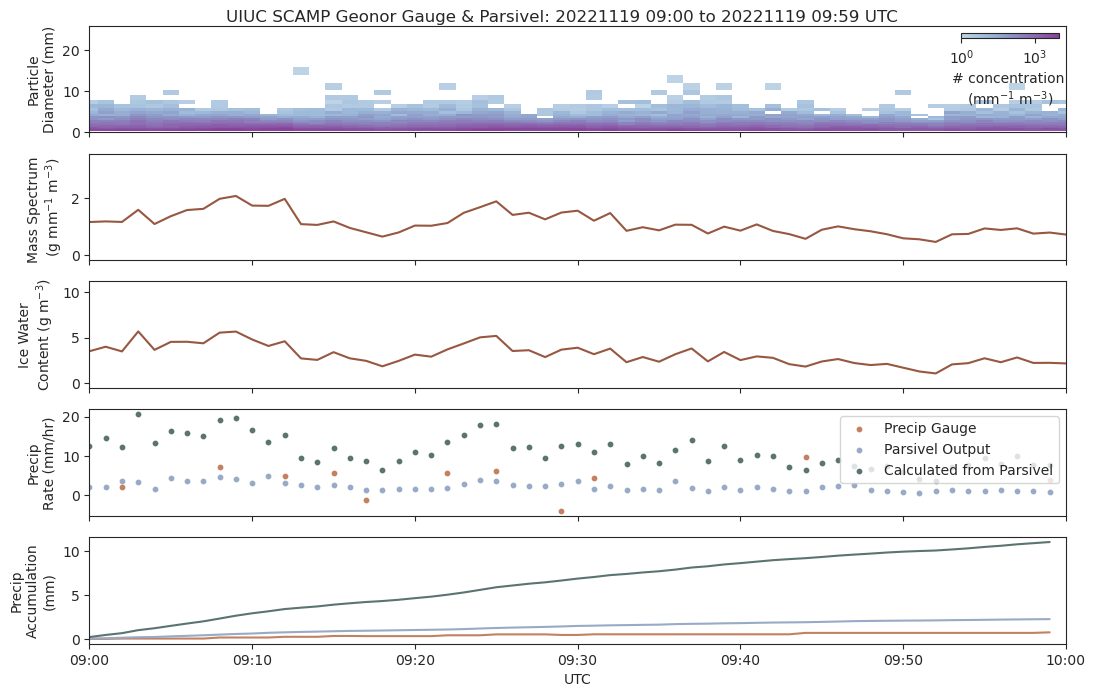

In [9]:
data['Parsivel Precip Accumulation'].replace(0, np.nan, inplace=True)
data['Processed Gauge Precip Rate'].replace(0, np.nan, inplace=True)
data['Parsivel Rainrate'].replace(0, np.nan, inplace=True)
data['Calculated Parsivel Rainrate'].replace(0, np.nan, inplace=True)

fig = plt.figure(figsize=(12.6,8.025))

ax=fig.subplots(nrows=5,ncols=1,sharex=True)

BuPu = cm.get_cmap('BuPu', 256)
newcmp = ListedColormap(BuPu(np.linspace(0.25, 0.75, 224)))

# Using Filtered Parsivel data
cb=ax[0].pcolormesh(pd.to_datetime(ds.time),ds.diameter,ds.dsd.T, norm=LogNorm(vmin=1e-0, vmax=10000),cmap = newcmp)
cbaxes = inset_axes(ax[0], width="10%", height="5%", loc='upper right') 
plt.colorbar(cb,cax=cbaxes,label='# concentration \n(mm$^{-1}$ m$^{-3}$)',orientation='horizontal')
ax[0].set_ylabel('Particle\nDiameter (mm)')
ax[0].set_xlim([xlimindexstart, xlimindexend+pd.Timedelta(minutes=1)])

if event_type == 'snow':
    ax[1].plot(pd.to_datetime(ds.time),ds.Heymsfield_massspec_warm_total,color='#975741', label='Heymsfield 2010 Warm')
    #ax[5].plot(pd.to_datetime(ds.time),ds.Matrosov_massspec_total,color='#82AB45', label='Matrosov')
    #ax[5].plot(pd.to_datetime(ds.time),ds.Heymsfield_massspec_conv_total,color='#952533', label='Conv Coeff')
    #ax[4].legend()
    ax[1].set_ylabel('Mass Spectrum \n(g mm$^{-1}$ m$^{-3}$)', fontsize='medium')
    
    ax[2].plot(pd.to_datetime(ds.time),ds.IWC_total,color='#975741')
    ax[2].set_ylabel('Ice Water\nContent (g m$^{-3}$)')
else:
    ax[1].plot(pd.to_datetime(ds.time),ds.raindrop_mass_spectrum_total,color='#975741')
    ax[1].set_ylabel('Mass Spectrum\n(g mm$^{-1}$ m$^{-3}$)', fontsize='medium')
    ax[2].plot(pd.to_datetime(ds.time),ds.Williams_LWC_total,label='N(D)D$^{3}$dD',color='#975741')
    ax[2].set_ylabel('Liquid Water\nContent (g m$^{-3}$)')

if event_type == 'snow':
    ax[3].scatter(data['times'], list(data['Processed Gauge Precip Rate']),color='#c38162', s=10, label='Precip Gauge')
    ax[3].scatter(data['times'], list(data['Parsivel Rainrate']),color='#98aac5', s=10, label='Parsivel Output')
    ax[3].scatter(data['times'], list(data['Calculated Parsivel Rainrate']),color='#5b7471', s=10, label='Calculated from Parsivel')
    ax[3].legend()
    ax[3].set_ylabel('Precip\nRate (mm/hr)')

    ax[4].plot(data['times'], list(data['Processed Gauge Precip Accumulation']),color='#c38162', label='Precip Gauge')
    ax[4].plot(data['times'], list(data['Parsivel Precip Accumulation']),color='#98aac5', label='Parsivel Output')
    ax[4].plot(data['times'], list(data['Calculated Parsivel Accumulation']),color='#5b7471', label='Calculated from Parsivel')
    ax[4].set_ylabel('Precip\nAccumulation\n(mm)')
    
else:
    ax[3].scatter(data['times'], list(data['Processed Gauge Precip Rate']),color='#c38162', s=10, label='Precip Gauge')
    ax[3].scatter(data['times'], list(data['Parsivel Rainrate']),color='#98aac5', s=10, label='Parsivel')
    ax[3].scatter(data['times'], list(data['Calculated Parsivel Rainrate']),color='#5b7471', s=10, label='Calculated from Parsivel')
    ax[3].legend()
    ax[3].set_ylabel('Precip\nRate (mm/hr)')

    ax[4].plot(data['times'], list(data['Processed Gauge Precip Accumulation']),color='#c38162', label='Precip Gauge')
    ax[4].plot(data['times'], list(data['Parsivel Precip Accumulation']),color='#98aac5', label='Parsivel')
    ax[4].plot(data['times'], list(data['Calculated Parsivel Accumulation']),color='#5b7471', label='Calculated from Parsivel')
    ax[4].set_ylabel('Precip\nAccumulation\n(mm)')

#ax[0].plot(data['times'],list(data['Frequency']),color='#82AB45')
#ax[0].set_ylabel('Geonor\nFreq (Hz)')
    
ax[4].set_xlabel('UTC')
ax[4].set_xlim([xlimindexstart, xlimindexend+pd.Timedelta(minutes=1)])

fig.suptitle('UIUC SCAMP Geonor Gauge & Parsivel: '+xlimindexstart.strftime('%Y%m%d %H:%M')+' to '+xlimindexend.strftime('%Y%m%d %H:%M')+' UTC', y=0.90)

import matplotlib.dates as mdates
xformatter = mdates.DateFormatter('%H:%M')
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)


savedimage = '/data/keeling/a/mp46/Research/Saved_Images/Gauge_Parsivel_Rain_Cases/Gauge_Parsivel_BUF_'+yyyymmdd+'.png'
plt.savefig(savedimage,dpi=150)

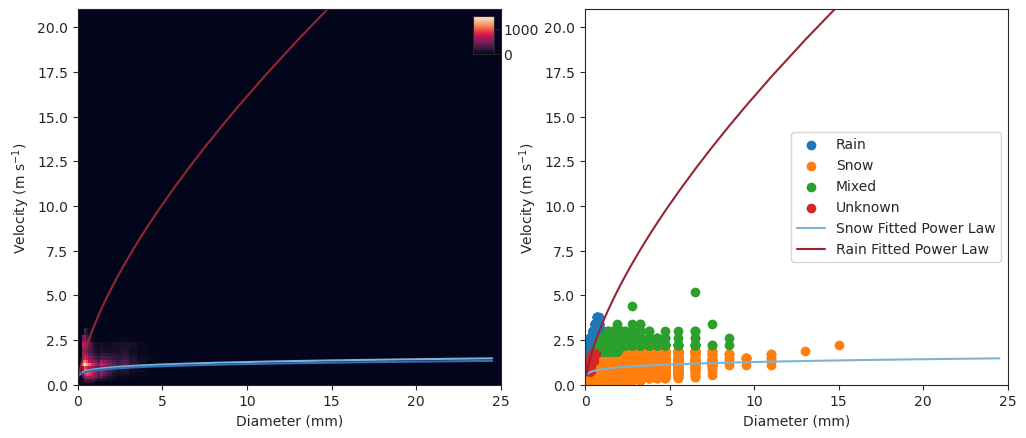

In [10]:
fig = plt.figure(figsize=(12,4.875))

ax=fig.subplots(nrows=1,ncols=2,sharex=True)

cb=ax[0].pcolormesh(ds.diameter,ds.velocity,summed_spectrum, vmin = 0, vmax=np.max(np.array(summed_spectrum)))
cbaxes = inset_axes(ax[0], width="5%", height="10%", loc='upper right') 
plt.colorbar(cb,cax=cbaxes,orientation='vertical') #label='# of Particles',

#ax[0].pcolor(ds.diameter,ds.velocity,summed_spectrum,vmin = 0, vmax=np.max(np.array(summed_spectrum)))


if event_type == 'snow':
    ax[0].plot(ds.diameter,(snow_pars[0])*np.power(ds.diameter/1000, snow_pars[1]), color = '#7cb3d3', label = 'Snow Fitted Power Law')
    ax[0].plot(ds.diameter,(rain_pars[0])*np.power(ds.diameter/1000, rain_pars[1]), color='#952533', label = 'Rain Fitted Power Law')
    ax[0].plot(ds.diameter,0.8*np.power(ds.diameter, 0.16), color='#3070B7', label = 'LH 1974 Aggs (Unrimed Dendrites)')
    ax[0].set_xlabel('Diameter (mm)')
    ax[0].set_ylabel('Velocity (m s$^{-1}$)')

    ax[0].set_ylim(0,21)
    ax[0].set_xlim(0,25)

    ax[1].scatter(rain_triple_time_dia_vel[:,0],rain_triple_time_dia_vel[:,1], label = 'Rain')
    ax[1].scatter(snow_triple_time_dia_vel[:,0],snow_triple_time_dia_vel[:,1], label = 'Snow')
    ax[1].scatter(mixed_triple_time_dia_vel[:,0],mixed_triple_time_dia_vel[:,1], label = 'Mixed')
    ax[1].scatter(unknown_triple_time_dia_vel[:,0],unknown_triple_time_dia_vel[:,1], label = 'Unknown')
    
    ax[1].plot(ds.diameter,(snow_pars[0])*np.power(ds.diameter/1000, snow_pars[1]), color = '#7cb3d3', label = 'Snow Fitted Power Law')
    ax[1].plot(ds.diameter,(rain_pars[0])*np.power(ds.diameter/1000, rain_pars[1]), color='#952533', label = 'Rain Fitted Power Law')
    #ax[1].plot(ds.diameter,0.8*np.power(ds.diameter, 0.16), color='#3070B7', label = 'Locatelli & Hobbs (1974) \n- Unrimed Dendrites')
    ax[1].legend()
    ax[1].set_xlabel('Diameter (mm)')
    ax[1].set_ylabel('Velocity (m s$^{-1}$)')

    ax[1].set_ylim(0,21)
    ax[1].set_xlim(0,25)
    ax[1].set_facecolor("white")

else:
    ax[0].plot(ds.diameter,rain_pars[0]*np.power(ds.diameter/1000, rain_pars[1]), color = '#7cb3d3', label = 'Fitted Power Law')
    ax[0].plot(ds.diameter,17.67*np.power(ds.diameter/10, 0.67), color = '#82AB45', label = 'Atlas and Ulbrich')
    ax[0].set_xlabel('Diameter (mm)')
    ax[0].set_ylabel('Velocity (m s$^{-1}$)')

    ax[0].set_ylim(0,20.8)
    ax[0].set_xlim(0,25)

    ax[1].scatter(rain_triple_time_dia_vel[:,0],rain_triple_time_dia_vel[:,1])
    ax[1].plot(ds.diameter,(rain_pars[0])*np.power(ds.diameter/1000, rain_pars[1]), color = '#7cb3d3', label = 'Fitted Power Law')
    ax[1].plot(ds.diameter,17.67*np.power(ds.diameter/10, 0.67), color = '#82AB45', label = 'Atlas and Ulbrich')
    ax[1].legend()
    ax[1].set_xlabel('Diameter (mm)')
    ax[1].set_ylabel('Velocity (m s$^{-1}$)')

    ax[1].set_ylim(0,20.8)
    ax[1].set_xlim(0,25)
    ax[1].set_facecolor("white")


savedimage = '/data/keeling/a/mp46/Research/Saved_Images/Gauge_Parsivel_Rain_Cases/Parsivel_Vt_vs_Diameter_BUF_'+yyyymmdd+'.png'
plt.savefig(savedimage,dpi=150)

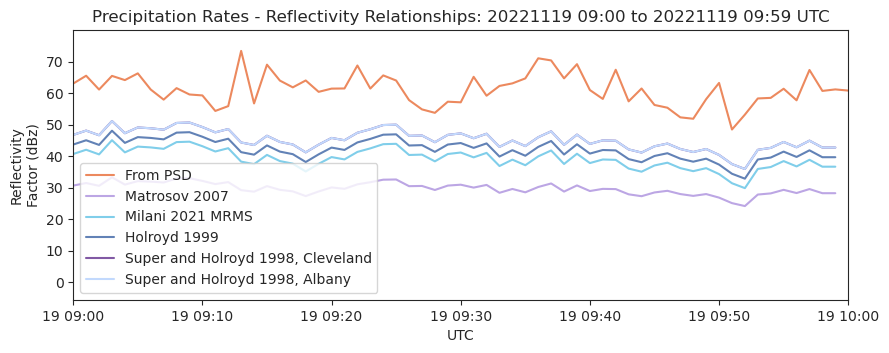

In [11]:
fig = plt.figure(figsize=(10,3.5))

#ax=fig.subplots(nrows=1,ncols=1,sharex=False)

if event_type == 'snow':
    #ax.plot(pd.to_datetime(ds.time),new_dbz, label='Derived by Parsivel')
    plt.plot(pd.to_datetime(ds.time),ds.total_dbz, color = '#ec895e', label='From PSD')
    plt.plot(data['times'],Matrosov_reflectivity_factor, color = '#bca6e4', label='Matrosov 2007')
    plt.plot(data['times'],MRMS_reflectivity_factor, color = '#80ceea', label='Milani 2021 MRMS')
    plt.plot(data['times'],Holroyd_reflectivity_factor, color = '#6282b6', label='Holroyd 1999')
    plt.plot(data['times'],WS_Cleveland_reflectivity_factor, color = '#8159a4', label='Super and Holroyd 1998, Cleveland')
    plt.plot(data['times'],WS_Albany_reflectivity_factor, color = '#c2d9fd', label='Super and Holroyd 1998, Albany')
    
    plt.ylabel('Reflectivity\nFactor (dBz)')
    plt.legend()
else:
    #ax.plot(pd.to_datetime(ds.time),new_dbz, label='Derived by Parsivel')
    plt.plot(pd.to_datetime(ds.time),ds.total_dbz, color = '#ec895e', label='From DSD')
    plt.plot(data['times'],Reinhart_reflectivity_factor, color = '#bca6e4', label='Marshall-Palmer')
    plt.plot(data['times'],Default_reflectivity_factor, color = '#80ceea', label='Default WSR-88D')
    plt.plot(data['times'],EastCool_reflectivity_factor, color = '#6282b6', label='East Cool Season')
    plt.ylabel('Reflectivity\nFactor (dBz)')
    plt.legend()
    
plt.xlabel('UTC')
plt.xlim([xlimindexstart, xlimindexend+pd.Timedelta(minutes=1)])

plt.title('Precipitation Rates - Reflectivity Relationships: '+xlimindexstart.strftime('%Y%m%d %H:%M')+' to '+xlimindexend.strftime('%Y%m%d %H:%M')+' UTC', y=1.0)

savedimage = '/data/keeling/a/mp46/Research/Saved_Images/Gauge_Parsivel_Rain_Cases/PrecipRate_Reflectivity_Relationships_Gauge_Parsivel_BUF_'+yyyymmdd+'.png'
plt.savefig(savedimage,dpi=150)

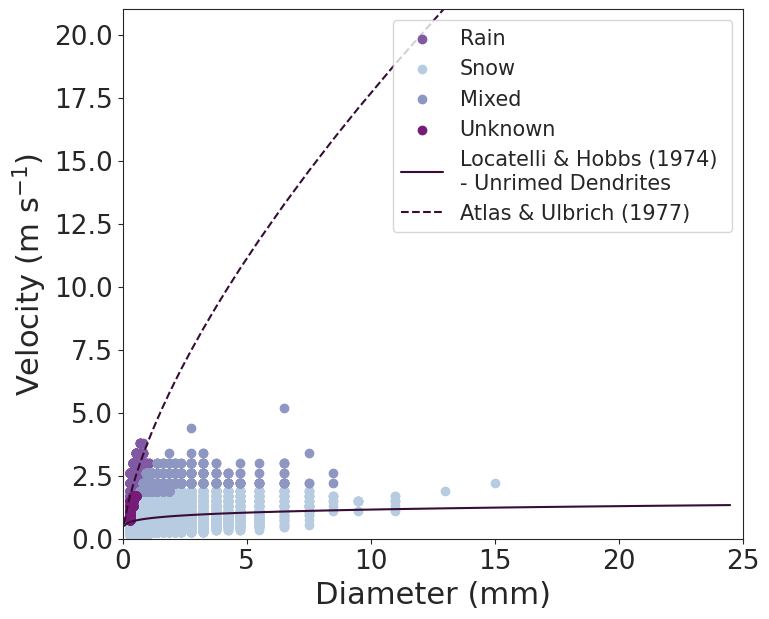

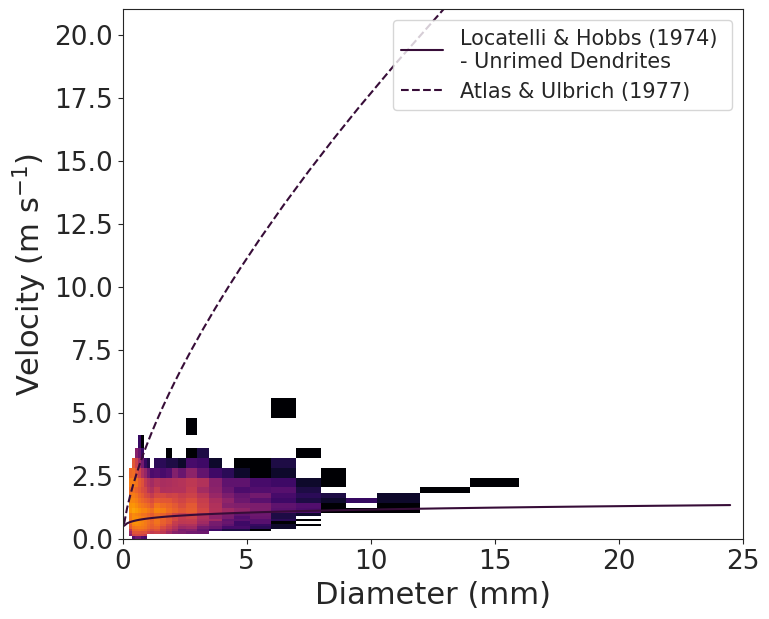

In [17]:
fig = plt.figure(figsize=(8,6.875))

if event_type == 'snow':
    plt.scatter(rain_triple_time_dia_vel[:,0],rain_triple_time_dia_vel[:,1], label = 'Rain', color = '#8158a2')
    plt.scatter(snow_triple_time_dia_vel[:,0],snow_triple_time_dia_vel[:,1], label = 'Snow', color = '#b8cce1')
    plt.scatter(mixed_triple_time_dia_vel[:,0],mixed_triple_time_dia_vel[:,1], label = 'Mixed', color = '#8e96c2')
    plt.scatter(unknown_triple_time_dia_vel[:,0],unknown_triple_time_dia_vel[:,1], label = 'Unknown', color = '#761c78')
    
    #plt.plot(ds.diameter,(snow_pars[0])*np.power(ds.diameter/1000, snow_pars[1]), color = '#370D38', linestyle='solid', label = 'Snow Fitted Power Law')
    #plt.plot(ds.diameter,(rain_pars[0])*np.power(ds.diameter/1000, rain_pars[1]), color='#370D38', linestyle='dashed', label = 'Rain Fitted Power Law')
    plt.plot(ds.diameter,0.8*np.power(ds.diameter, 0.16), color = '#370D38', linestyle='solid', label = 'Locatelli & Hobbs (1974) \n- Unrimed Dendrites')
    plt.plot(ds.diameter,17.67*np.power(ds.diameter/10, 0.67), color='#370D38', linestyle='dashed', label = 'Atlas & Ulbrich (1977)')
    plt.legend(fontsize = 15, loc = 'upper right')
    plt.xlabel('Diameter (mm)', fontsize = 22)
    plt.ylabel('Velocity (m s$^{-1}$)', fontsize = 22)
    plt.tick_params(axis='both', labelsize=19)

    plt.ylim(0,21)
    plt.xlim(0,25)

savedimage = '/data/keeling/a/mp46/Research/Saved_Images/Gauge_Parsivel_Rain_Cases/SingleScatterParsivel_Vt_vs_Diameter_BUF_'+yyyymmdd+'.png'
plt.savefig(savedimage,dpi=150)



fig = plt.figure(figsize=(8,6.875))

cb=plt.pcolormesh(ds.diameter,ds.velocity,summed_spectrum, norm=LogNorm(vmin=1e-0, vmax=10000),cmap='inferno')
#vmin = 0, vmax=np.max(np.array(summed_spectrum)),cmap='inferno')
#cbaxes = inset_axes(ax[0], width="5%", height="10%", loc='upper right') 
#plt.colorbar(cb,cax=cbaxes,orientation='vertical') #label='# of Particles',

plt.plot(ds.diameter,0.8*np.power(ds.diameter, 0.16), color = '#370D38', linestyle='solid', label = 'Locatelli & Hobbs (1974) \n- Unrimed Dendrites')
plt.plot(ds.diameter,17.67*np.power(ds.diameter/10, 0.67), color='#370D38', linestyle='dashed', label = 'Atlas & Ulbrich (1977)')
plt.legend(fontsize = 15, loc = 'upper right')
plt.xlabel('Diameter (mm)', fontsize = 22)
plt.ylabel('Velocity (m s$^{-1}$)', fontsize = 22)
plt.tick_params(axis='both', labelsize=19)

plt.ylim(0,21)
plt.xlim(0,25)

savedimage = '/data/keeling/a/mp46/Research/Saved_Images/Gauge_Parsivel_Rain_Cases/HeatMapParsivel_Vt_vs_Diameter_BUF_'+yyyymmdd+'.png'
plt.savefig(savedimage,dpi=300, bbox_inches='tight')

In [13]:
# Plotting MRR Data
'''
time = dt.datetime(2022,1,17)

yyyymm = time.strftime('%Y%m')
mmdd = time.strftime('%m%d')
input_file = '/data/accp/a/snesbitt/scamp/mrr/RawSpectra/'+yyyymm+'/'+mmdd+'.raw'
output_dir = os.path.dirname(input_file.replace('RawSpectra','processed'))

fileOut = input_file.replace('raw','nc').replace('RawSpectra','processed')
imageOut = '/data/keeling/a/mp46/Research/Saved_Images/Gauge_Parsivel_Rain_Cases/Short_MRR_BUF_'+yyyymmdd+'.png'

ds = xr.open_dataset(fileOut)
ds['height']=ds['height'].isel(time=0)

ds = ds.swap_dims({'range':'height'})

fig = plt.figure(figsize=(14.5,4))
ds['Ze'].T.plot( vmin=-10,vmax=40,cmap='terrain')
plt.xlabel('')
fig.suptitle('UIUC SCAMP MRR-2 preliminary data - Lancaster, NY Plot created:'+str(ds.time.values[-1]),fontsize=15);
plt.savefig(imageOut,dpi=150)
'''

"\ntime = dt.datetime(2022,1,17)\n\nyyyymm = time.strftime('%Y%m')\nmmdd = time.strftime('%m%d')\ninput_file = '/data/accp/a/snesbitt/scamp/mrr/RawSpectra/'+yyyymm+'/'+mmdd+'.raw'\noutput_dir = os.path.dirname(input_file.replace('RawSpectra','processed'))\n\nfileOut = input_file.replace('raw','nc').replace('RawSpectra','processed')\nimageOut = '/data/keeling/a/mp46/Research/Saved_Images/Gauge_Parsivel_Rain_Cases/Short_MRR_BUF_'+yyyymmdd+'.png'\n\nds = xr.open_dataset(fileOut)\nds['height']=ds['height'].isel(time=0)\n\nds = ds.swap_dims({'range':'height'})\n\nfig = plt.figure(figsize=(14.5,4))\nds['Ze'].T.plot( vmin=-10,vmax=40,cmap='terrain')\nplt.xlabel('')\nfig.suptitle('UIUC SCAMP MRR-2 preliminary data - Lancaster, NY Plot created:'+str(ds.time.values[-1]),fontsize=15);\nplt.savefig(imageOut,dpi=150)\n"

In [14]:
'''
# Z = AR^b
b = np.divide(7 + mu, 4.67 + mu)
A_exp = np.power(N0,np.divide(-2.33,4.67+mu))
A_num = 10**6 * gamma(7 + mu) * A_exp
A_denom = np.power(33.31 * gamma(4.67+1),b)
A = A_num/A_denom

# D0 = epsilonR^delta
delta = np.divide(1, 4.67 + mu)
epsilon_num = 3.67 + mu
epsilon_denom = np.power(33.31*N0*gamma(4.67+1),b)
epsilon = psilon_num/epsilon_denom

# NT = xiR^eta
eta = np.divide(1 + mu, 4.67 + mu)
xi_exp = np.power(N0,np.divide(3.67,4.67+mu))
xi_num = gamma(1 + mu) * xi_exp
xi_denom = np.power(33.31 * gamma(4.67+mu),eta)
xi = xi_num/xi_denom

# LWC = zetaR^kappa
kappa = np.divide(4 + mu, 4.67 + mu)
zeta_exp = np.power(N0,np.divide(0.67,4.67+mu))
zeta_num = np.pi * gamma(4 + mu) * zeta_exp
xi_denom = np.power(33.31 * gamma(4.67+mu),kappa)
xi = xi_num/6*xi_denom

fig = plt.figure(figsize=(6,4.875))

plt.yscale("log") 
plt.xscale("log")
plt.xlabel('R (mm h$^{-1}$)')
plt.ylabel('Z (mm$^{6}$ m$^{-3}$)')

plt.ylim(1,1000000)
plt.xlim(0.01,100)
'''

'\n# Z = AR^b\nb = np.divide(7 + mu, 4.67 + mu)\nA_exp = np.power(N0,np.divide(-2.33,4.67+mu))\nA_num = 10**6 * gamma(7 + mu) * A_exp\nA_denom = np.power(33.31 * gamma(4.67+1),b)\nA = A_num/A_denom\n\n# D0 = epsilonR^delta\ndelta = np.divide(1, 4.67 + mu)\nepsilon_num = 3.67 + mu\nepsilon_denom = np.power(33.31*N0*gamma(4.67+1),b)\nepsilon = psilon_num/epsilon_denom\n\n# NT = xiR^eta\neta = np.divide(1 + mu, 4.67 + mu)\nxi_exp = np.power(N0,np.divide(3.67,4.67+mu))\nxi_num = gamma(1 + mu) * xi_exp\nxi_denom = np.power(33.31 * gamma(4.67+mu),eta)\nxi = xi_num/xi_denom\n\n# LWC = zetaR^kappa\nkappa = np.divide(4 + mu, 4.67 + mu)\nzeta_exp = np.power(N0,np.divide(0.67,4.67+mu))\nzeta_num = np.pi * gamma(4 + mu) * zeta_exp\nxi_denom = np.power(33.31 * gamma(4.67+mu),kappa)\nxi = xi_num/6*xi_denom\n\nfig = plt.figure(figsize=(6,4.875))\n\nplt.yscale("log") \nplt.xscale("log")\nplt.xlabel(\'R (mm h$^{-1}$)\')\nplt.ylabel(\'Z (mm$^{6}$ m$^{-3}$)\')\n\nplt.ylim(1,1000000)\nplt.xlim(0.01,100)\n

1.532793954940525


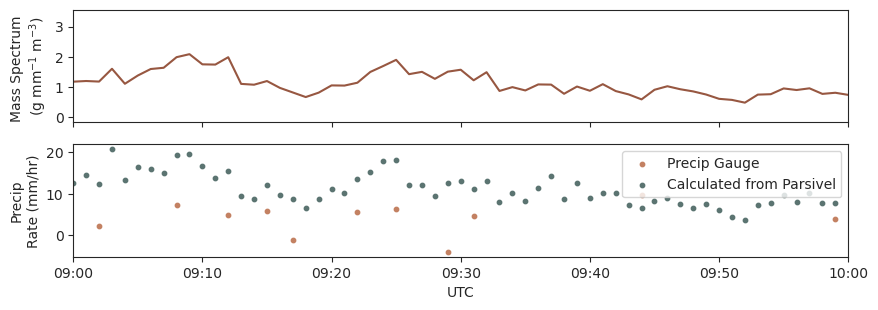

In [15]:
# Looking at Heymsfield Mass and Precip Rate in Detail

gauge = data['Processed Gauge Precip Rate']
parsivel = data['Calculated Parsivel Rainrate']

mean_square_error = np.sum(parsivel-gauge) / len(gauge)
print(mean_square_error)

fig = plt.figure(figsize=(10,3.21))

ax=fig.subplots(nrows=2,ncols=1,sharex=True)

ax[0].plot(pd.to_datetime(ds.time),ds.Heymsfield_massspec_warm_total,color='#975741', label='Heymsfield 2010 Warm')
ax[0].set_ylabel('Mass Spectrum \n(g mm$^{-1}$ m$^{-3}$)', fontsize='medium')

ax[1].scatter(data['times'], list(data['Processed Gauge Precip Rate']),color='#c38162', s=10, label='Precip Gauge')
#ax[1].scatter(data['times'], list(data['Parsivel Rainrate']),color='#98aac5', s=10, label='Parsivel Output')
ax[1].scatter(data['times'], list(data['Calculated Parsivel Rainrate']),color='#5b7471', s=10, label='Calculated from Parsivel')
ax[1].legend()
ax[1].set_ylabel('Precip\nRate (mm/hr)')

ax[1].set_xlabel('UTC')
ax[1].set_xlim([xlimindexstart, xlimindexend+pd.Timedelta(minutes=1)])

#fig.suptitle('UIUC SCAMP Geonor Gauge & Parsivel: '+xlimindexstart.strftime('%Y%m%d %H:%M')+' to '+xlimindexend.strftime('%Y%m%d %H:%M')+' UTC', y=0.90)

import matplotlib.dates as mdates
xformatter = mdates.DateFormatter('%H:%M')
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)

savedimage = '/data/keeling/a/mp46/Research/Saved_Images/Gauge_Parsivel_Rain_Cases/Mass_PrecipRate_BUF_'+yyyymmdd+'.png'
plt.savefig(savedimage,dpi=150)

In [16]:
drop_diameter = [
    0.062, 0.187, 0.312, 0.437, 0.562, 0.687, 0.812, 0.937, 1.062, 1.187, 1.375, 1.625,
    1.875, 2.125, 2.375, 2.750, 3.25, 3.75, 4.25, 4.75, 5.5, 6.5, 7.5, 8.5, 9.5, 11, 
    13, 15, 17, 19, 21.5, 24.5] #diameters from the OTT Parsivel2 manual

heymsfield_power = np.power(np.divide(drop_diameter,10),2.1)
heymsfield_warm_mass = np.multiply(0.00359,heymsfield_power)

drop_diameter_melted = np.cbrt(np.divide(6*heymsfield_warm_mass,np.pi*1))

frozen_volume = (4/3)*np.pi*np.power(np.array(drop_diameter)/20,3)
melted_volume = (4/3)*np.pi*np.power(np.array(drop_diameter_melted)/20,3)
density_frozen = heymsfield_warm_mass/frozen_volume
density_melted = heymsfield_warm_mass/melted_volume